In [1]:
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import cmath
import math
from scipy import io, stats
from scipy.stats import mannwhitneyu, normaltest, zscore, wilcoxon, ttest_rel
from statannotations.Annotator import Annotator
import matplotlib as mpl
import matplotlib.patheffects as path_effects

cwd = os.getcwd()
sys.path.append(cwd+"/../handy_functions")

from concat_pickles import get_outputs,get_outputs_wTraces,print_df
from metrics import get_R2

fig_folder = '/Users/kendranoneman/Figures/neural-decoding'

data = io.loadmat('/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/vars/vars-pa29dir4A-pre500-post300.mat')
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)
sess_size = len(out_times)
print(sess_size)

reds =[(1.0, 0.0, 0.0), (0.95, 0.0, 0.0), (0.9, 0.0, 0.0), (0.8, 0.0, 0.0), (0.7, 0.0, 0.0), (0.6, 0.0, 0.0), (0.5, 0.0, 0.0), (0.4, 0.0, 0.0), (0.3, 0.0, 0.0), (0.2, 0.0, 0.0)]
oranges = [[1.0, 0.6, 0.0], [1.0, 0.5, 0.0], [0.9, 0.45,0.0], [0.9, 0.4, 0.0], [0.8, 0.4, 0.0], [0.7, 0.3, 0.0], [0.6, 0.2, 0.0], [0.5, 0.1, 0.0]]
pinks = [[1.0, 0.6, 0.7], [1.0, 0.55, 0.7], [1.0, 0.45, 0.65], [1.0, 0.3, 0.6], [0.9, 0.25, 0.6], [0.8, 0.2, 0.55], [0.7, 0.15, 0.5], [0.6, 0.1, 0.45]]
grays = [(0.95,0.75,0.75),(0.9,0.7,0.7),(0.85,0.65,0.65),(0.8,0.6,0.6),(0.75,0.55,0.55),(0.7,0.5,0.5),(0.65,0.45,0.45),(0.6,0.4,0.4)]

pal = [reds,oranges,pinks]
%matplotlib inline

3817600


# Figure 1 : decoding pipeline

In [ ]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/'
dt = 50
data = io.loadmat(data_folder+'vars/vars-pa29dir4A-pre500-post300.mat')

spike_times  =  data['spike_times'] # spike times of all neurons
pos          =  data['pos'] # x and y eye positions
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)

conditions = data['contConditions']

spike_times  =  np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]  =  np.squeeze(spike_times[i])
    
unts = pd.read_csv(data_folder+'units/units-pa29dir4A-pre500-post300.csv')
fef = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'FEF') & (unts['DI'] > 0.25)].index
mt = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'MT') & (unts['DI'] > 0.15)].index
    
##############################################################################################
trial = [1858] #1858. 1861. 1879. 1882. 1883.

spikes = []
for sublist in spike_times:
    s = sublist[np.logical_and(sublist>np.where(np.isin(conditions[:,0],trial))[0][0], sublist<np.where(np.isin(conditions[:,0],trial))[0][-1])]
    spikes.append(s)
    
fig, ax = plt.subplots(figsize=(5, 3))
fig.tight_layout()

ax.eventplot([spikes[i] for i in fef], colors='mediumpurple', linelengths=0.5, linewidths=1, lineoffsets=np.arange(len([spikes[i] for i in fef])));
ax.eventplot([spikes[i] for i in mt], colors='forestgreen', linelengths=0.5, linewidths=1, lineoffsets=np.arange(len([spikes[i] for i in fef]),len([spikes[i] for i in fef])+len([spikes[i] for i in mt])));

ax.axis('off')
#ax.set_xticks([0,100])
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(fig_folder+'/examp_spikes.png', dpi=600, bbox_inches='tight')

##############################################################
fig2, ax = plt.subplots(figsize=(4.25, 2))
fig2.tight_layout()

poses = pos[np.isin(conditions[:,0],trial)]

ax.plot(poses[:,0], label='HE', color='gray', linestyle='--', linewidth=3)
ax.plot(poses[:,1], label='VE', color='gray', linestyle='-', linewidth=3)

#ax.set_xlim(400,900)

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig2.savefig(fig_folder+'/examp_eyepos.png', dpi=600, bbox_inches='tight')

# Figure 2: benchmarked decoding performance

In [ ]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/runs/'
sub_folder = 'figures-2_4/'

column_names = ['sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','model','output','nMT','nFEF','repeat','outer_fold','R2_train','rho_train','R2','rho','R2_shuf','rho_shuf','eval_full','prms','preProcess_time','train_time','test_time']
df0, conds0, yTest_all0, yTestPred_all0 = get_outputs_wTraces(data_folder+sub_folder,["-o0-"],column_names)
df1, conds1, yTest_all1, yTestPred_all1 = get_outputs_wTraces(data_folder+sub_folder,["-o1-"],column_names)
df2, conds2, yTest_all2, yTestPred_all2 = get_outputs_wTraces(data_folder+sub_folder,["-o2-"],column_names)

df = pd.concat([df0,df1,df2],ignore_index=False)
all_r2 = []
for i in range(10):
    all_r2.append(df0.loc[(df0['model']==7)].groupby('outer_fold')['R2_mn'].mean().values[i].mean())
best_fold = np.array(all_r2).argmax()

df['num_bins'] = sess_size / df['output_binWidth']
df['preProcessTime_corrected'] = df['preProcess_time'] / df['num_bins']
df['inference_time'] = df['test_time'] + df['preProcessTime_corrected']
df['train_time'] = df['train_time'] / 60

df.head(1)

In [ ]:
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(1,1,figsize=(7,3),sharex=True) #6,5.5
fig.tight_layout()

lw = 1.25
lstyles = ['dotted','dotted','dotted','dotted','dashed','dashed','dashed','dashed']

y_test = yTest_all0
y_test_predicted = yTestPred_all0

mdls = df0[(df0['outer_fold'] == best_fold) & (df0['downsample_factor'] == 1) & (df0['output_binWidth'] == 50)].index.values
jmdls =[0,1,3,4,5,6,7,8]

conds = conds0[mdls[0]]
trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]
print(np.unique(trl_dirs))

plot_trls = []
for d in np.unique(trl_dirs):
    R2_all,trl_names = [],[]
    for t in trl_nums[np.array(trl_dirs==d)]:
        start_end = np.where(np.isin(conds[:, 0],t))[0]

        i = 0
        X_true = y_test[mdls[i]][start_end,0]
        Y_true = y_test[mdls[i]][start_end,1]

        X_pred = y_test_predicted[mdls[i]][start_end,0]
        Y_pred = y_test_predicted[mdls[i]][start_end,1]

        R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))
        R2_all.append(R2.mean())
        trl_names.append(t)

    R2_all = np.array(R2_all)
    trl_names = np.array(trl_names)

    Nts = 1
    pt_trls = trl_names[np.argsort(R2_all)[-Nts:]]
    bad_trls = trl_names[np.argsort(R2_all)[:Nts]]
    
    plot_trls.append(pt_trls)

#################
start_end = np.where(np.isin(conds[:, 0],plot_trls))[0]
#print(conds[start_end,2])
#x = np.arange(0, start_end.shape[0]*10*Nts, 10*Nts) / 1000
x = np.linspace(0,Nts*1.6,start_end.shape[0])

axes.plot(x,y_test[mdls[0]][start_end,1], color=(0.4,0.4,0.4), alpha=0.3, linewidth=5, label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    if j==0 or j==8:
        axes.plot(x,y_test_predicted[i][start_end,1], color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        test = get_R2(y_test[mdls[0]][start_end,:],y_test_predicted[i][start_end,:]).mean()
        
        text_box = f"$R^2$ = {test:.2f}"
        axes.text(1.0, 0.1-0.01*j, text_box, transform=axes.transAxes, fontsize=12, ha='right', va='bottom', color=reds[j])

    else:
        blah = 0
        #axes[1].plot(x,y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]), color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        #test = get_R2(y_test[mdls[0]][start_end,1],y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]))
    

axes.set_xlim(x[0],x[-1])
axes.set_ylim(-15,15)
axes.set_yticks([-10,0,10])
#axes[1].set_xticks([0,1,2,3,4,5,6,7,8])
axes.spines['right'].set_color('none')
axes.spines['top'].set_color('none')

'''
y_test = yTest_all1
y_test_predicted = yTestPred_all1

axes[1].plot(x,y_test[mdls[0]][start_end,1], color=(0.4,0.4,0.4), alpha=0.3, linewidth=3, label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    if j==0 or j==8:
        axes[1].plot(x,y_test_predicted[i][start_end,1], color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        test = get_R2(y_test[mdls[0]][start_end,1],y_test_predicted[i][start_end,1])
        
        text_box = f"$R^2$ = {test:.2f}"
        axes[1].text(1.0, 0.15-0.014*j, text_box, transform=axes[1].transAxes, fontsize=12, ha='right', va='bottom', color=reds[j])

    else:
        blah = 0
        #axes[1].plot(x,y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]), color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        #test = get_R2(y_test[mdls[0]][start_end,1],y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]))

axes[1].set_xlim(x[0],x[-1])
axes[1].set_ylim(-40,30)
#axes[1].set_yticks([-40,0,40])
#axes[1].set_xticks([0,1,2,3,4,5,6,7,8])
axes[1].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')

y_test = yTest_all2
y_test_predicted = yTestPred_all2

axes[2].plot(x,y_test[mdls[0]][start_end,1], color=(0.4,0.4,0.4), alpha=0.3, linewidth=3, label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    if j==0 or j==8:
        axes[2].plot(x,y_test_predicted[i][start_end,1], color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        test = get_R2(y_test[mdls[0]][start_end,1],y_test_predicted[i][start_end,1])
        
        text_box = f"$R^2$ = {test:.2f}"
        axes[2].text(1.0, 0.12-0.013*j, text_box, transform=axes[2].transAxes, fontsize=12, ha='right', va='bottom', color=reds[j])

    else:
        blah = 0
        #axes[1].plot(x,y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]), color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        #test = get_R2(y_test[mdls[0]][start_end,1],y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]))
    
axes[2].set_xlim(x[0],x[-1])
axes[2].set_ylim(-350,250)
axes[2].set_yticks([-200,0,200])
#axes[1].set_xticks([0,1,2,3,4,5,6,7,8])
axes[2].spines['right'].set_color('none')
axes[2].spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.25, hspace=0.1)
'''
fig.savefig(fig_folder+'/traces_8models-pos2.png', dpi=600, bbox_inches='tight')

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1,1,figsize=(4,3),sharex=True) #6,5.5
fig.tight_layout()

#################
y_test = yTest_all0
y_test_predicted = yTestPred_all0

axes.plot(y_test[mdls[0]][start_end,0],y_test[mdls[0]][start_end,1], color=(0.4,0.4,0.4), alpha=0.3, linewidth=5, label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    if j==0 or j==8:
        axes.plot(y_test_predicted[i][start_end,0],y_test_predicted[i][start_end,1], color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        test = get_R2(y_test[mdls[0]][start_end,:],y_test_predicted[i][start_end,:]).mean()
        
        #text_box = f"$R^2$ = {test:.2f}"
        #axes.text(1.0, 0.15-0.015*j, text_box, transform=axes.transAxes, fontsize=12, ha='right', va='bottom', color=reds[j])

    else:
        blah = 0
        #axes[1].plot(x,y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]), color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        #test = get_R2(y_test[mdls[0]][start_end,1],y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]))
    

#axes.set_xlim(x[0],x[-1])
#axes.set_ylim(-23,20)
#axes.set_yticks([-15,0,15])
#axes[1].set_xticks([0,1,2,3,4,5,6,7,8])
axes.spines['right'].set_color('none')
axes.spines['top'].set_color('none')

'''
y_test = yTest_all1
y_test_predicted = yTestPred_all1

axes[1].plot(x,y_test[mdls[0]][start_end,1], color=(0.4,0.4,0.4), alpha=0.3, linewidth=3, label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    if j==0 or j==8:
        axes[1].plot(x,y_test_predicted[i][start_end,1], color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        test = get_R2(y_test[mdls[0]][start_end,1],y_test_predicted[i][start_end,1])
        
        text_box = f"$R^2$ = {test:.2f}"
        axes[1].text(1.0, 0.15-0.014*j, text_box, transform=axes[1].transAxes, fontsize=12, ha='right', va='bottom', color=reds[j])

    else:
        blah = 0
        #axes[1].plot(x,y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]), color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        #test = get_R2(y_test[mdls[0]][start_end,1],y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]))

axes[1].set_xlim(x[0],x[-1])
axes[1].set_ylim(-40,30)
#axes[1].set_yticks([-40,0,40])
#axes[1].set_xticks([0,1,2,3,4,5,6,7,8])
axes[1].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')

y_test = yTest_all2
y_test_predicted = yTestPred_all2

axes[2].plot(x,y_test[mdls[0]][start_end,1], color=(0.4,0.4,0.4), alpha=0.3, linewidth=3, label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    if j==0 or j==8:
        axes[2].plot(x,y_test_predicted[i][start_end,1], color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        test = get_R2(y_test[mdls[0]][start_end,1],y_test_predicted[i][start_end,1])
        
        text_box = f"$R^2$ = {test:.2f}"
        axes[2].text(1.0, 0.12-0.013*j, text_box, transform=axes[2].transAxes, fontsize=12, ha='right', va='bottom', color=reds[j])

    else:
        blah = 0
        #axes[1].plot(x,y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]), color=reds[j], linewidth=lw, linestyle='solid', label='predicted (horizontal)',zorder=j+1)
        #test = get_R2(y_test[mdls[0]][start_end,1],y_test_predicted[i][start_end,1]*np.std(y_test[mdls[0]]))
    
axes[2].set_xlim(x[0],x[-1])
axes[2].set_ylim(-350,250)
axes[2].set_yticks([-200,0,200])
#axes[1].set_xticks([0,1,2,3,4,5,6,7,8])
axes[2].spines['right'].set_color('none')
axes[2].spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.25, hspace=0.1)
'''
fig.savefig(fig_folder+'/traces_8models-pos3.png', dpi=600, bbox_inches='tight')

In [ ]:
########################################### position ##########################################
values = ['R2_mn','R2sh_mn']
b = 50
o = 'position'

wf   = (df.loc[(df['model']==0) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
wc   = (df.loc[(df['model']==1) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
#kf   = (df.loc[(df['model']==2) & (df['sess']==sess) & (df['output_binWidth']==b) & (df['downsample_factor']==1)]).groupby('outer_fold')[values].mean().values
xgb   = (df.loc[(df['model']==3) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
svr   = (df.loc[(df['model']==4) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
dnn  = (df.loc[(df['model']==5) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
rnn  = (df.loc[(df['model']==6) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
gru  = (df.loc[(df['model']==7) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values
lstm = (df.loc[(df['model']==8) & (df['output']==o) & (df['output_binWidth']==b)]).groupby('outer_fold')[values].mean().values

n=10
means=([np.mean(wf,axis=0),np.mean(wc,axis=0),np.mean(xgb,axis=0),np.mean(svr,axis=0),np.mean(dnn,axis=0),np.mean(rnn,axis=0),np.mean(gru,axis=0),np.mean(lstm,axis=0)])
err=([np.std(wf,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(wc,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(xgb,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(svr,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(dnn,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(rnn,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(gru,axis=0)*np.sqrt(1./n+1./(n-1)),np.std(lstm,axis=0)*np.sqrt(1./n+1./(n-1))])
ind = np.arange(len(err)) #X values for plotting

# Standard R2
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1,1, figsize=(4, 3), sharey=True)
fig.tight_layout()
val = 0

for pos, y, yerr, color in zip(ind, means, err, reds): #Loop through methods and plot error bars
    ax.errorbar(pos, y[val], yerr[val], lw=3, capsize=6, capthick=3, color=color, zorder=0)

    ax.set_xticks([0,1,2,3,4,5,6,7])
    ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0) #,'gru','lstm'
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')

    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(len(means))),(len(means)*10,1))
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #,gru,lstm
    
    scatter_y = np.expand_dims(scatter_y[:,val], axis=1)
    
    colors_list=[] 
    for j in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(reds[j])
        
    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.08,zorder=1)
    ax.set_yticks([0.6,0.7,0.8,0.9])

#ax.set_ylim(0.4,0.9);
fig.savefig(fig_folder+'/mnR2_8models-pos2.png', dpi=600, bbox_inches='tight')


# Figure 3: Cross-decoding across target conditions

In [9]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/runs/'
sub_folder = 'cosyne/cross_decoding'

column_names = ['sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','model','output','condition','trainCondition','testCondition','nMT','nFEF','repeat','outer_fold','R2_train','rho_train','R2','rho','R2_shuf','rho_shuf','eval_full','prms','preProcess_time','train_time','test_time','neuronInds']
df = get_outputs(data_folder+sub_folder,["-o0-"],column_names)

df['train-test'] = df['trainCondition'] + '-' + df['testCondition']
df['mt-fef'] = df['nMT'].astype(str) + '-' + df['nFEF'].astype(str)

df.head(5)

,sess,timePrePost,output_binWidth,downsample_factor,input_timeWindow,input_binWidth,model,output,condition,trainCondition,...,rho_y,rho_mn,R2sh_x,R2sh_y,R2sh_mn,R2tr_x,R2tr_y,R2tr_mn,train-test,mt-fef
0,18,0,50,1,400,50,0,position,speed,s10,...,0.285887,0.306100,-0.030669,-0.047650,-0.039160,0.062453,0.075114,0.068783,s10-s10,12-12
1,18,0,50,1,400,50,0,position,speed,s10,...,0.256393,0.328996,-0.015899,-0.036291,-0.026095,0.062423,0.075123,0.068773,s10-s20,12-12
2,18,0,50,1,400,50,0,position,speed,s10,...,0.291949,0.318995,-0.012101,-0.023984,-0.018043,0.062460,0.075116,0.068788,s10-sAl,12-12
3,18,0,50,1,400,50,0,position,speed,s20,...,0.286274,0.305757,-0.093894,-0.084374,-0.089134,0.110766,0.073746,0.092256,s20-s10,12-12
4,18,0,50,1,400,50,0,position,speed,s20,...,0.270706,0.317453,-0.048297,-0.053712,-0.051004,0.095006,0.064390,0.079698,s20-s20,12-12


In [10]:
from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator
from utils import *

dff2 = df.groupby(['mt-fef','train-test','outer_fold','repeat','model','condition',"R2tr_mn","sess"])["R2_mn"].mean().reset_index(name="mR2")
dff2 = dff2.loc[(dff2['mt-fef']!='24-24') & (dff2['mt-fef']!='24-41') & (dff2['mt-fef']!='12-12')]

dff2.head(10)

,mt-fef,train-test,outer_fold,repeat,model,condition,R2tr_mn,sess,mR2
0,0-24,c012-c012,0,0,0,contrast,0.586861,29,0.515922
1,0-24,c012-c012,0,0,8,contrast,0.825624,29,0.667522
2,0-24,c012-c012,0,1,0,contrast,0.438469,29,0.420951
3,0-24,c012-c012,0,1,8,contrast,0.712963,29,0.616730
4,0-24,c012-c012,0,2,0,contrast,0.450157,29,0.325148
5,0-24,c012-c012,0,2,8,contrast,0.793327,29,0.424674
6,0-24,c012-c012,0,3,0,contrast,0.488449,29,0.422178
7,0-24,c012-c012,0,3,8,contrast,0.695910,29,0.558845
8,0-24,c012-c012,0,4,0,contrast,0.470320,29,0.402221
9,0-24,c012-c012,0,4,8,contrast,0.772430,29,0.554517


['c012-c012' 'c012-c100' 'c012-cAll' 'c100-c012' 'c100-c100' 'c100-cAll'
 'cAll-c012' 'cAll-c100' 'cAll-cAll' 's10-s10' 's10-s20' 's10-sAl'
 's20-s10' 's20-s20' 's20-sAl' 'sAl-s10' 'sAl-s20' 'sAl-sAl']
['0-24' '24-0']


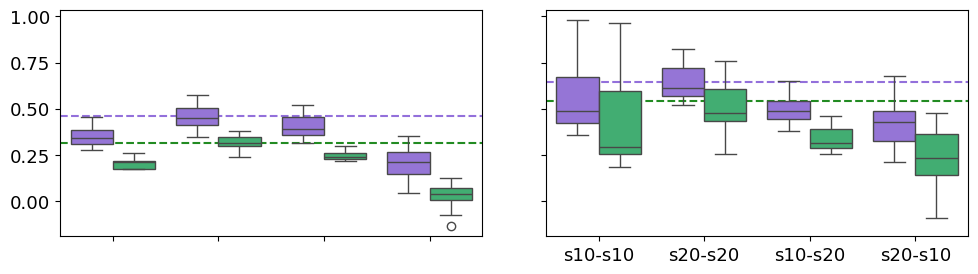

In [35]:
print(df2['train-test'].unique())
print(df2['mt-fef'].unique())

plt.rcParams.update({'font.size': 13})

df2 = dff2.loc[dff2['sess']==29]
#df2 = dff2.loc[dff2['sess']>24]


fig, axes = plt.subplots(1,2,figsize=(10,3), sharey=True)
fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)

pairs = [
    [('s10-s10','0-24'), ('s20-s20','0-24')],
    [('s10-s10','0-24'), ('s10-s20','0-24')],
    [('s10-s10','0-24'), ('s20-s10','0-24')],
    [('s20-s20','0-24'), ('s10-s20','0-24')],
    [('s20-s20','0-24'), ('s20-s10','0-24')],
    [('s10-s20','0-24'), ('s20-s10','0-24')],
    
    [('s10-s10','24-0'), ('s20-s20','24-0')],
    [('s10-s10','24-0'), ('s10-s20','24-0')],
    [('s10-s10','24-0'), ('s20-s10','24-0')],
    [('s20-s20','24-0'), ('s10-s20','24-0')],
    [('s20-s20','24-0'), ('s20-s10','24-0')],
    [('s10-s20','24-0'), ('s20-s10','24-0')],
]

pal = ['mediumpurple','mediumseagreen']
order = ['s10-s10','s20-s20','s10-s20','s20-s10']

hue_plot_params = {'data': df2.loc[(df2['model']==0) & (df2['condition']=='speed')],'x': 'train-test','y': 'mR2', 'hue': 'mt-fef', 'palette': pal, 'order': order, 'saturation': 0.9}
a1 = sns.boxplot(ax=axes[0], **hue_plot_params,zorder=3)

'''
hue_plot_params = {'data': df2.loc[(df2['model']==0) & (df2['condition']=='speed')],'x': 'train-test','y': 'R2tr_mn', 'hue': 'mt-fef', 'palette': pal, 'order': order, 'saturation': 0.5, 'fill': False}
a1b = sns.boxplot(ax=axes[0], **hue_plot_params,zorder=2)

for i, artist in enumerate(a1b.artists):
    # Get the edge color of the boxplot
    edge_color = sns.color_palette(pal)[i % len(order)]
    
    # Change saturation of the edge color
    new_edge_color = sns.desaturate(edge_color, 0.3)  # Adjust saturation here
    
    # Set the modified edge color to the boxplot edges
    for line in a1b.lines[i * 5:i * 5 + 5]:
        line.set_color(new_edge_color)
'''

a1.axhline(df2.loc[(df2['train-test']=='sAl-sAl') & (df2['mt-fef']=='0-24') & (df2['model']==0)  & (df2['condition']=='speed')]['mR2'].values.mean(),linestyle='--',color='mediumpurple',zorder=1)
a1.axhline(df2.loc[(df2['train-test']=='sAl-sAl') &(df2['mt-fef']=='24-0') & (df2['model']==0)  & (df2['condition']=='speed')]['mR2'].values.mean(),linestyle='--',color='forestgreen',zorder=0)
#a1.axhline(df2.loc[(df2['train-test']=='sAl-sAl') &(df2['mt-fef']=='12-12')]['mR2'].values.mean(),linestyle='--',color='yellow',zorder=0)

#a1.set_ylim(-0.3,1.75)
#annotator = Annotator(axes[0], pairs, **hue_plot_params)
#annotator.configure(test="Mann-Whitney").apply_and_annotate()
a1.set(xlabel=None)
a1.set(ylabel=None)
#a1.set_ylim(-0.17,1.05)
a1.set(xticklabels=[])
#a1.set_yticks([0,0.2,0.4,0.6,0.8,1])
#a1.set(xlabel='train-test')
#a1.set(title='speed')
a1.get_legend().remove()     

hue_plot_params = {'data': df2.loc[(df2['model']==6)  & (df2['condition']=='speed')],'x': 'train-test','y': 'mR2', 'hue': 'mt-fef', 'palette': pal, 'order': order, 'saturation': 0.9}
a2 = sns.boxplot(ax=axes[1], **hue_plot_params,zorder=3)

'''
hue_plot_params = {'data': df2.loc[(df2['model']==6) & (df2['condition']=='speed')],'x': 'train-test','y': 'R2tr_mn', 'hue': 'mt-fef', 'palette': pal, 'order': order, 'saturation': 0.5, 'fill': False}
a2b = sns.boxplot(ax=axes[1], **hue_plot_params,zorder=2)

for i, artist in enumerate(a2b.artists):
    # Get the edge color of the boxplot
    edge_color = sns.color_palette(pal)[i % len(order)]
    
    # Change saturation of the edge color
    new_edge_color = sns.desaturate(edge_color, 0.3)  # Adjust saturation here
    
    # Set the modified edge color to the boxplot edges
    for line in a1b.lines[i * 5:i * 5 + 5]:
        line.set_color(new_edge_color)
'''
 
a2.axhline(df2.loc[(df2['train-test']=='sAl-sAl') & (df2['mt-fef']=='0-24') & (df2['model']==8)  & (df2['condition']=='speed')]['mR2'].values.mean(),linestyle='--',color='mediumpurple',zorder=1)
a2.axhline(df2.loc[(df2['train-test']=='sAl-sAl') &(df2['mt-fef']=='24-0') & (df2['model']==8)  & (df2['condition']=='speed')]['mR2'].values.mean(),linestyle='--',color='forestgreen',zorder=0)
#a2.axhline(df2.loc[(df2['train-test']=='sAl-sAl') &(df2['mt-fef']=='12-12')]['mR2'].values.mean(),linestyle='--',color='yellow',zorder=0)

#a2.set_ylim(-0.17,1.05)
#annotator = Annotator(axes[1], pairs, **hue_plot_params)
#annotator.configure(test="Mann-Whitney").apply_and_annotate()
a2.set(xlabel=None)
a2.set(ylabel=None)
#a2.set(xticklabels=[])
#a2.set_yticks([0,0.2,0.4,0.6,0.8,1])
#a2.set(xlabel='train-test')
#a2.set(title='speed')
a2.get_legend().remove() 

plt.subplots_adjust(wspace=0.15, hspace=0.1)
            
#fig.savefig(fig_folder+'/R2_crossSpeed_s29.png', dpi=600, bbox_inches='tight') 

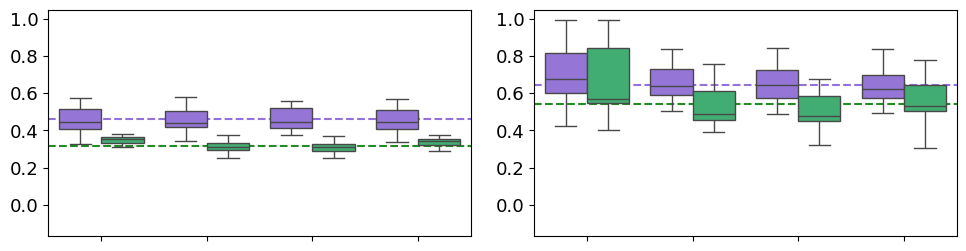

In [36]:
plt.rcParams.update({'font.size': 13})

fig, axes = plt.subplots(1,2,figsize=(10,3), sharey=False)
fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)

df2 = dff2.loc[dff2['sess']==29]

pairs = [
    [('c012-c100','0-24'), ('c100-c100','0-24')],
    [('c012-c012','0-24'), ('c012-c100','0-24')],
    [('c012-c012','0-24'), ('c100-c012','0-24')],
    [('c100-c100','0-24'), ('c012-c100','0-24')],
    [('c100-c100','0-24'), ('c100-c012','0-24')],
    [('c012-c100','0-24'), ('c100-c012','0-24')],
    
    [('c012-c100','24-0'), ('c100-c100','24-0')],
    [('c012-c012','24-0'), ('c012-c100','24-0')],
    [('c012-c012','24-0'), ('c100-c012','24-0')],
    [('c100-c100','24-0'), ('c012-c100','24-0')],
    [('c100-c100','24-0'), ('c100-c012','24-0')],
    [('c012-c100','24-0'), ('c100-c012','24-0')],
]

pal = ['mediumpurple','mediumseagreen']
order = ['c012-c012','c100-c100','c012-c100','c100-c012']

hue_plot_params = {'data': df2.loc[(df2['model']==0) & (df2['condition']=='contrast')],'x': 'train-test','y': 'mR2', 'hue': 'mt-fef', 'palette': pal, 'order': order, 'saturation': 0.9}
a1 = sns.boxplot(ax=axes[0], **hue_plot_params,zorder=3)

'''
hue_plot_params = {'data': df2.loc[(df2['model']==0) & (df2['condition']=='contrast')],'x': 'train-test','y': 'R2tr_mn', 'hue': 'mt-fef', 'palette': pal, 'order': order, 'saturation': 0.5, 'fill': False}
a1b = sns.boxplot(ax=axes[0], **hue_plot_params,zorder=2)

for i, artist in enumerate(a1b.artists):
    # Get the edge color of the boxplot
    edge_color = sns.color_palette(pal)[i % len(order)]
    
    # Change saturation of the edge color
    new_edge_color = sns.desaturate(edge_color, 0.3)  # Adjust saturation here
    
    # Set the modified edge color to the boxplot edges
    for line in a1b.lines[i * 5:i * 5 + 5]:
        line.set_color(new_edge_color)
'''

a1.axhline(df2.loc[(df2['train-test']=='sAl-sAl') & (df2['mt-fef']=='0-24') & (df2['model']==0)  & (df2['condition']=='speed')]['mR2'].values.mean(),linestyle='--',color='mediumpurple',zorder=1)
a1.axhline(df2.loc[(df2['train-test']=='sAl-sAl') &(df2['mt-fef']=='24-0') & (df2['model']==0)  & (df2['condition']=='speed')]['mR2'].values.mean(),linestyle='--',color='forestgreen',zorder=0)
#a1.axhline(df2.loc[(df2['train-test']=='sAl-sAl') &(df2['mt-fef']=='12-12')]['mR2'].values.mean(),linestyle='--',color='yellow',zorder=0)

#a1.set_ylim(-0.3,1.75)
#annotator = Annotator(axes[0], pairs, **hue_plot_params)
#annotator.configure(test="Mann-Whitney").apply_and_annotate()
a1.set(xlabel=None)
a1.set(ylabel=None)
a1.set_ylim(-0.17,1.05)
a1.set(xticklabels=[])
a1.set_yticks([0,0.2,0.4,0.6,0.8,1])
#a1.set(xlabel='train-test')
#a1.set(title='speed')
a1.get_legend().remove()     

hue_plot_params = {'data': df2.loc[(df2['model']==8)  & (df2['condition']=='contrast')],'x': 'train-test','y': 'mR2', 'hue': 'mt-fef', 'palette': pal, 'order': order, 'saturation': 0.9}
a2 = sns.boxplot(ax=axes[1], **hue_plot_params,zorder=3)

'''
hue_plot_params = {'data': df2.loc[(df2['model']==8) & (df2['condition']=='contrast')],'x': 'train-test','y': 'R2tr_mn', 'hue': 'mt-fef', 'palette': pal, 'order': order, 'saturation': 0.5, 'fill': False}
a2b = sns.boxplot(ax=axes[1], **hue_plot_params,zorder=2)

for i, artist in enumerate(a2b.artists):
    # Get the edge color of the boxplot
    edge_color = sns.color_palette(pal)[i % len(order)]
    
    # Change saturation of the edge color
    new_edge_color = sns.desaturate(edge_color, 0.3)  # Adjust saturation here
    
    # Set the modified edge color to the boxplot edges
    for line in a1b.lines[i * 5:i * 5 + 5]:
        line.set_color(new_edge_color)
'''

a2.axhline(df2.loc[(df2['train-test']=='sAl-sAl') & (df2['mt-fef']=='0-24') & (df2['model']==8)  & (df2['condition']=='speed')]['mR2'].values.mean(),linestyle='--',color='mediumpurple',zorder=1)
a2.axhline(df2.loc[(df2['train-test']=='sAl-sAl') &(df2['mt-fef']=='24-0') & (df2['model']==8)  & (df2['condition']=='speed')]['mR2'].values.mean(),linestyle='--',color='forestgreen',zorder=0)
#a2.axhline(df2.loc[(df2['train-test']=='sAl-sAl') &(df2['mt-fef']=='12-12')]['mR2'].values.mean(),linestyle='--',color='yellow',zorder=0)

a2.set_ylim(-0.17,1.05)
#annotator = Annotator(axes[1], pairs, **hue_plot_params)
#annotator.configure(test="Mann-Whitney").apply_and_annotate()
a2.set(xlabel=None)
a2.set(ylabel=None)
a2.set(xticklabels=[])
a2.set_yticks([0,0.2,0.4,0.6,0.8,1])
#a2.set(xlabel='train-test')
#a2.set(title='speed')
a2.get_legend().remove() 

plt.subplots_adjust(wspace=0.15, hspace=0.1)
        
        
#fig.savefig(fig_folder+'/R2_crossContrast_s29.png', dpi=600, bbox_inches='tight') 